In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import torch.nn.functional as F
import torch.nn as nn

from torch.optim.lr_scheduler import ReduceLROnPlateau

'''
Running cells with 'pytorch3d' requires the ipykernel package.
Run the following command to install 'ipykernel' into the Python environment. 
Command: 'conda install -n pytorch3d ipykernel --update-deps --force-reinstall'
'''

"\nRunning cells with 'pytorch3d' requires the ipykernel package.\nRun the following command to install 'ipykernel' into the Python environment. \nCommand: 'conda install -n pytorch3d ipykernel --update-deps --force-reinstall'\n"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
if torch.cuda.is_available():
     torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
# min_xyz = -5
# max_xyz = 5
min_xyz = torch.tensor(-2, dtype=torch.float32, device=device)
max_xyz = torch.tensor(4, dtype=torch.float32, device=device)
axis_len = max_xyz - min_xyz
axis_num_pts = 200
x = torch.linspace(min_xyz, max_xyz, axis_num_pts, device=device)
y = torch.linspace(min_xyz, max_xyz, axis_num_pts, device=device)
z = torch.linspace(min_xyz, max_xyz, axis_num_pts, device=device)
X, Y, Z = torch.meshgrid(x, y, z)
stacked_tensor = torch.stack([X, Y, Z], dim=3).to(device)
reshaped_tensor = torch.reshape(stacked_tensor, (-1, 3)).to(device)

In [5]:
print(reshaped_tensor)

tensor([[-2.0000, -2.0000, -2.0000],
        [-2.0000, -2.0000, -1.9698],
        [-2.0000, -2.0000, -1.9397],
        ...,
        [ 4.0000,  4.0000,  3.9397],
        [ 4.0000,  4.0000,  3.9698],
        [ 4.0000,  4.0000,  4.0000]])


In [6]:
def rotate_xyz(p, angles):
    '''
    Reference: http://www.songho.ca/opengl/gl_anglestoaxes.html
    '''
    p = p.to(device)
    angles = angles.to(device)
    θx, θy, θz = angles
    # θx = torch.FloatTensor([θx * 3.14159 / 180.0], device=device)
    # θy = torch.FloatTensor([θy * 3.14159 / 180.0], device=device)
    # θz = torch.FloatTensor([θz * 3.14159 / 180.0], device=device)
    θx = torch.tensor([θx * 3.14159 / 180.0], device=device)
    θy = torch.tensor([θy * 3.14159 / 180.0], device=device)
    θz = torch.tensor([θz * 3.14159 / 180.0], device=device)
    R_zyx = torch.tensor([ 
        [torch.cos(θz)*torch.cos(θy), -torch.sin(θz)*torch.cos(θx) + torch.cos(θz)*torch.sin(θy)*torch.sin(θx), torch.sin(θz)*torch.sin(θx)+torch.cos(θz)*torch.sin(θy)*torch.cos(θx)],
        [torch.sin(θz)*torch.cos(θy), torch.cos(θz)*torch.cos(θx)+torch.sin(θz)*torch.sin(θy)*torch.sin(θx), -torch.cos(θz)*torch.sin(θx)+torch.sin(θz)*torch.sin(θy)*torch.cos(θx)],
        [-torch.sin(θy), torch.cos(θy)*torch.sin(θx), torch.cos(θy)*torch.cos(θx)]
    ], device=device)
    return torch.matmul(p, R_zyx.T)

# Sphere

In [7]:
def sdf_sphere(p, r, center, angles):
    # p = p.to(device)
    # r = r.to(device)
    # center = center.to(device)
    # angles = angles.to(device)
    p_rotated = rotate_xyz(p, angles)
    return torch.sqrt(torch.sum((p_rotated - center)**2, dim=1)) - r

In [8]:
r=1
center = torch.tensor([1, 1, 1], device=device)
angles = torch.tensor([0, 0, 0], device=device)
sphere1_signed_distances_vec = sdf_sphere(reshaped_tensor, r, center, angles)
# occupancy_vec = ()

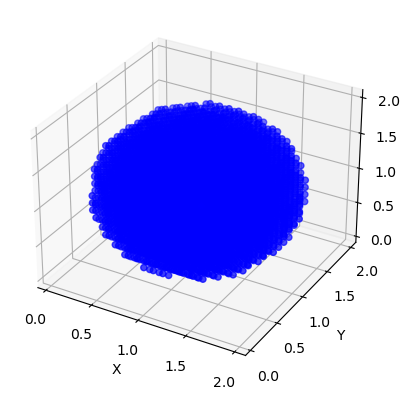

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Get the indices of the nonzero elements in the occupancy_vec tensor
# ax.scatter(reshaped_tensor[sphere1_signed_distances_vec <= 0, 0], reshaped_tensor[sphere1_signed_distances_vec <= 0,1], reshaped_tensor[sphere1_signed_distances_vec <= 0, 2], c='blue', marker='o')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# # ax.view_init(elev=30, azim=100)
# plt.show()

# Move the tensors to CPU and convert to NumPy arrays
sphere1_signed_distances_np = sphere1_signed_distances_vec.cpu().numpy()
reshaped_tensor_np = reshaped_tensor.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the indices of the nonzero elements in the occupancy_vec tensor
ax.scatter(
    reshaped_tensor_np[sphere1_signed_distances_np <= 0, 0],
    reshaped_tensor_np[sphere1_signed_distances_np <= 0, 1],
    reshaped_tensor_np[sphere1_signed_distances_np <= 0, 2],
    c='blue',
    marker='o'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# Box

In [7]:
def sdBox(p, b, center, angles):
    '''
    p = point to be tested, nx3 tensor
    b = half the length of box, i.e. coordinates of the corner from the center
    center = center of the box
    angles = rotation angles in degrees
    '''
    p_rotated = rotate_xyz(p, angles)
    q = torch.abs(p_rotated-center) - b
    return torch.norm(torch.max(q, torch.tensor([0.,0.,0.])), dim=1) + torch.min(torch.max(q, dim=1)[0], torch.tensor([0.]))

In [8]:
b = torch.tensor([1, 1, 1])
center = torch.tensor([1, 1, 1])
angles = torch.tensor([30, 0, 0])
box_signed_distances = sdBox(reshaped_tensor, b, center, angles)
# print("box_signed_distances shape:", box_signed_distances.shape)

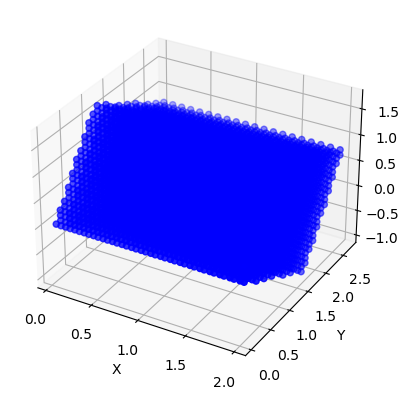

In [21]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(reshaped_tensor[box_signed_distances <= 0, 0], reshaped_tensor[box_signed_distances <= 0,1], reshaped_tensor[box_signed_distances <= 0, 2], c='blue', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
# ax.view_init(elev=30, azim=100)
plt.show()

# Torus

In [75]:
def sdTorus(p, t, center, angles):
    '''
    p = point to be tested, nx3 tensor
    t = torus parameters as tuple (r, R)
    center = center of the torus
    angles = rotation angles in degrees
    '''
    no_points = p.shape[0]
    p = rotate_xyz(p, angles)
    p = p - center
    t = t.reshape(1,2)
    temp1 = (torch.norm(p[:, [0,2]], dim=1) - t[:, 0]).reshape(no_points, 1)
    temp2 = p[:, 1].reshape(no_points, 1)
    q = torch.cat([temp1, temp2], dim=1)
    temp3 = (torch.norm(q, dim=1)).reshape(no_points, 1) - t[:, 1]
    return temp3.squeeze()


In [76]:
radius = torch.tensor([3,2])
center = torch.tensor([0, 0, 0]).reshape(1,3)
angles = torch.tensor([0, 0, 0])
torus_signed_distances = sdTorus(reshaped_tensor, radius, center, angles)

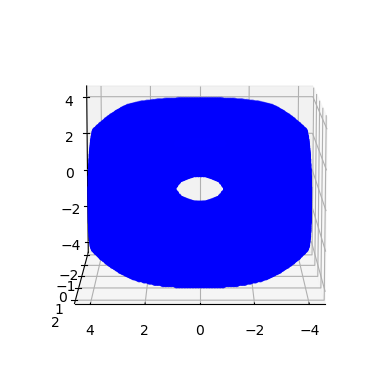

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[torus_signed_distances <= 0, 0], reshaped_tensor[torus_signed_distances <= 0,1], reshaped_tensor[torus_signed_distances <= 0, 2], c='blue', marker='o')
ax.view_init(elev=10, azim=90)
plt.show()

# Triangular Prism

In [78]:

def sdTriPrism(p, h, center, angles):
    '''
    p = point to be tested, nx3 tensor
    h = half height and half width of base triangle, 2-element tensor
    center = center of the triangular prism
    angles = rotation angles in degrees
    Note: The constant 0.866025 in the code is the square root of 3 divided by 2, and is used to simplify the computation of the signed distance function. The 0.866025 factor is the tangent of 60 degrees, the angle between the side face and the base of the prism.
    '''
    # rotate point
    p_rotated = rotate_xyz(p, angles)

    # translate to center
    p_translated = p_rotated - center
    
    # compute signed distance
    q = torch.abs(p_translated)   # nx3 tensor having absolute values of x, y, z coordinates of p_translated
    d = torch.max(torch.cat([q[:, [2]]-h[1], (q[:, [0]]*0.866025 + p_translated[:, [1]]*0.5), (-p_translated[:, [1]])-h[0]*0.5], dim=1), dim=1)[0]

    return d

In [79]:
h = torch.tensor([4,4])
center = torch.tensor([0, 0, 0])
angles = torch.tensor([0, 0, 0])
triPrism_signed_distances = sdTriPrism(reshaped_tensor, h, center, angles)

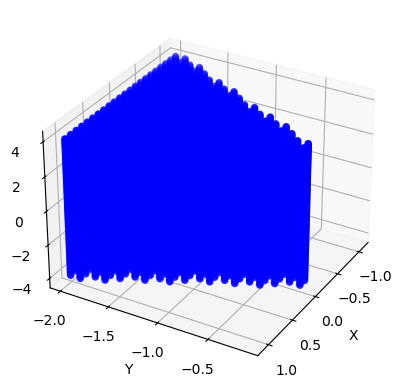

In [80]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(reshaped_tensor[triPrism_signed_distances <= 0, 0], reshaped_tensor[triPrism_signed_distances <= 0,1], reshaped_tensor[triPrism_signed_distances <= 0, 2], c='blue', marker='o')
ax2.view_init(elev=30, azim=30)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.show()

# Cone

In [81]:
def sdCone(p, c, h, center=torch.tensor([0, 0, 0]), angles=torch.tensor([0, 0, 0])):
    '''
    c is the sin/cos of the angle, h is height. Alternatively pass q instead of (c,h), which is the point at the base in 2D q = torch.tensor([h * c[0] / c[1], -h, 0.0])
    '''
    reshape_no = p.shape[0]
    q = torch.tensor([h * c[0] / c[1], -h]).reshape(2,1)
    q_diag = torch.diag(q.squeeze())

    # Apply rotation and translation
    p_rotated = rotate_xyz(p, angles)
    p_rotated_centered = p_rotated - center

    # Concatenate norms and elem1 along the second dimension
    w = torch.cat((torch.norm(p_rotated_centered[:, [0, 2]], dim=1).unsqueeze(1), p_rotated_centered[:, 1].unsqueeze(1)), dim=1)
    
    temp2 = torch.clamp(torch.matmul(w, q) / torch.matmul(q.T, q), 0.0, 1.0).reshape(reshape_no, 1)    
    a = w - torch.matmul(torch.cat((temp2, temp2), dim=1), q_diag)

    b = w - torch.cat((q[0] * torch.clamp(w[:,0] / q[0], 0.0, 1.0).reshape(reshape_no, 1), q[1] * torch.ones(reshape_no, 1)), dim=1)

    k = torch.sign(q[1])
    d = torch.min(a[:,0] * a[:,0] + a[:,1] * a[:,1], b[:,0] * b[:,0] + b[:,1] * b[:,1])

    s = torch.max(k * (w[:, 0] * q[1] - w[:, 1] * q[0]), k * (w[:, 1] - q[1]))
    return torch.sqrt(d) * torch.sign(s)

In [82]:
α = 45
α = torch.FloatTensor([α * 3.141592653589793 / 180])
c = torch.FloatTensor([torch.sin(α/2), torch.cos(α/2)])
h = torch.FloatTensor([3.0])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 30])
cone_signed_distances = sdCone(reshaped_tensor, c, h, center, angles)

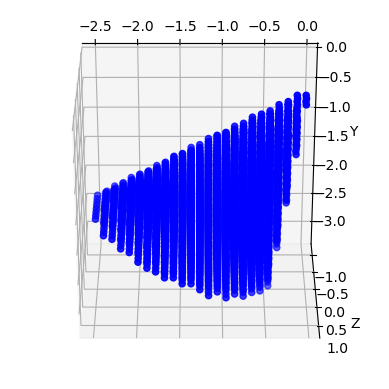

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[cone_signed_distances <= 0, 0], reshaped_tensor[cone_signed_distances <= 0,1], reshaped_tensor[cone_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=120, azim=-90)
plt.show()

# Hexagonal Prism

In [84]:
def sdHexPrism(p, h, center, angles):
    p = rotate_xyz(p, angles)
    p = p - center
    no_point = p.shape[0]
    k = torch.tensor([-0.8660254, 0.5, 0.57735]).reshape(1, 3)
    p = torch.abs(p)
    
    min_dot = torch.min(k[0,0]*p[:, 0] + k[0,1]*p[:, 1], torch.tensor(0.0)).reshape(no_point, 1)
    p[:, :2] -= 2.0 * torch.matmul(min_dot, k[0, :2].reshape(1, 2))

    d1 = torch.norm(p[:, :2] - torch.clamp(p[:, 0:2], -k[0, 2] * h[0], k[0,2] * h[0]), dim=1) * torch.sign(p[:, 1] - h[0])
    d2 = p[:, 2] - h[1]
    d = torch.stack((d1, d2), dim=1)
    return torch.min(torch.max(d[:, 0], d[:, 1]), torch.tensor(0.0)) + torch.norm(torch.max(d, torch.tensor(0.0)), dim=1)

In [85]:
h = torch.FloatTensor([1.0,4.0])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([90, 0, 90])
# p = torch.FloatTensor([[1, 1, 1], [-1, -2, 2], [1, -2, 3], [1, 3, 2], [2, 1, 2], [3, 4, 5]])
hexPrism_signed_distances = sdHexPrism(reshaped_tensor, h, center, angles)

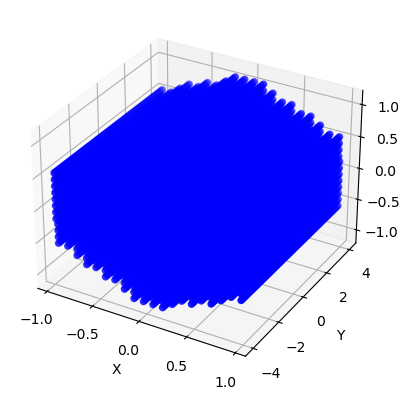

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[hexPrism_signed_distances <= 0, 0], reshaped_tensor[hexPrism_signed_distances <= 0,1], reshaped_tensor[hexPrism_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.view_init(elev=45, azim=45)
plt.show()

# Capsule

In [208]:
def sdCapsule(p, a, b, r, center, angles):
    """
    Calculates the signed distance of a point or points to a capsule defined by two end points (a, b) and a radius (r).
    
    Arguments:
    p -- a tensor of size (n, 3) representing the point(s) to calculate the signed distance for
    a -- a tensor of size (3,) representing the first end point of the capsule
    b -- a tensor of size (3,) representing the second end point of the capsule
    r -- a float representing the radius of the capsule
    
    Returns:
    A 1D tensor of size (n,) representing the signed distance(s) of the point(s) to the capsule
    """
    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    no_points = p.shape[0]
    a = a.expand(no_points, -1)  # -1 means expand along that dimension
    b = b.expand(no_points, -1)
    r = r.expand(no_points, -1)
    pa = p - a
    ba = b - a
    h = torch.clamp(torch.sum(pa * ba, dim=1) / torch.sum(ba * ba, dim = 1), 0, 1).reshape(no_points, 1)
    return (torch.norm(pa - ba * h, dim=1).reshape(no_points, 1) - r).squeeze()

In [209]:
a = torch.FloatTensor([0,0, 3])
b = torch.FloatTensor([0,0, -3])
r = torch.FloatTensor([2])
center = torch.FloatTensor([2, 0, 0])
angles = torch.FloatTensor([30, 0, 0])
capsule_signed_distances = sdCapsule(reshaped_tensor, a, b, r, center, angles)

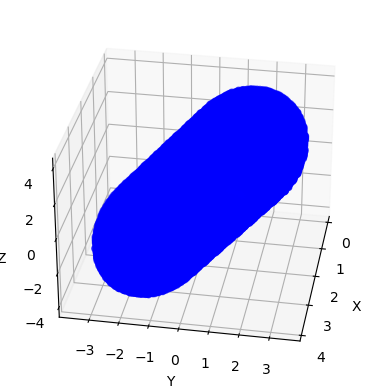

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[capsule_signed_distances <= 0, 0], reshaped_tensor[capsule_signed_distances <= 0,1], reshaped_tensor[capsule_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=30, azim=10)
plt.show()

# Verticle Capsule

In [90]:
def sdCapsule2(p, h, r, center, angles):
    no_points = p.shape[0]
    r = r.expand(no_points, -1)

    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    p[:,1] -= torch.clamp(p[:,1], torch.FloatTensor([0]), h)
    return (torch.norm(p, dim=1).reshape(no_points,1) - r).squeeze()

In [91]:
h = torch.FloatTensor([5])
r = torch.FloatTensor([3])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
capsule_signed_distances2 = sdCapsule2(reshaped_tensor, h, r, center, angles)

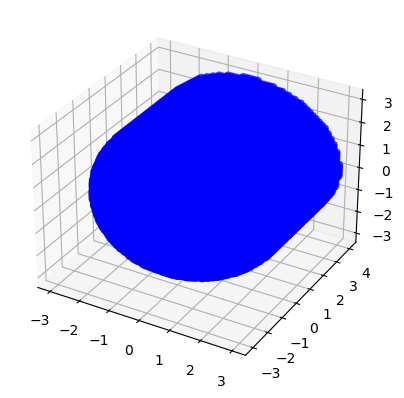

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[capsule_signed_distances2 <= 0, 0], reshaped_tensor[capsule_signed_distances2 <= 0,1], reshaped_tensor[capsule_signed_distances2 <= 0, 2], c='blue', marker='o')
# ax.view_init(elev= 20, azim=0)
plt.show()


# Octahedron - bound (not exact)

In [93]:
def sdOctahedron(p, s, center, angles):
    '''
    s = size of the octahedron
    Constant 0.57735027 = 1/sqrt(3). This scaling factor is necessary to ensure that the distance function is normalized, meaning that the distance at the surface of the shape is equal to 1.
    '''
    no_points = p.shape[0]
    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    q = torch.abs(p)
    return (q[:,0] + q[:,1] + q[:,2] - s)*0.57735027

In [94]:
s = torch.FloatTensor([3])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
octahedron_signed_distances = sdOctahedron(reshaped_tensor, s, center, angles)

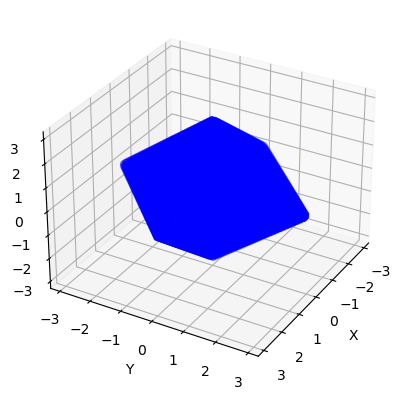

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[octahedron_signed_distances <= 0, 0], reshaped_tensor[octahedron_signed_distances <= 0,1], reshaped_tensor[octahedron_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev= 30, azim=30)
plt.show()

# Ellipsoid - bound (not exact!)

In [96]:
def sdEllipsoid(p, r, center, angles):
    '''
    r: 3D vector r that specifies the radii of the ellipsoid along each axis

    '''
    no_points = p.shape[0]
    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    r = torch.reshape(r, (1,3))
    k0 = torch.norm(p/r, dim=1).reshape(no_points, 1)
    k1 = torch.norm(p/(r*r), dim=1).reshape(no_points, 1)
    return (k0*(k0-1)/k1).squeeze()

In [97]:
r = torch.FloatTensor([3, 1.5, 0.5])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
ellipsoid_signed_distances = sdEllipsoid(reshaped_tensor, r, center, angles)

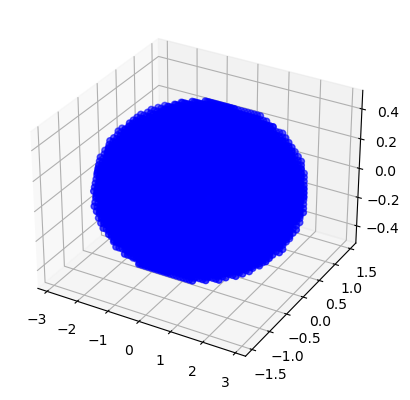

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[ellipsoid_signed_distances <= 0, 0], reshaped_tensor[ellipsoid_signed_distances <= 0,1], reshaped_tensor[ellipsoid_signed_distances <= 0, 2], c='blue', marker='o')
# ax.view_init(elev= 0, azim=0)
plt.show()

# Link - exact 

In [99]:
def sdLink(p, le, r1, r2, center, angles):
    '''
    le: link length
    r1: radius of the first cylinder
    r2: radius of the second cylinder
    '''
    no_points = p.shape[0]
    p = rotate_xyz(p, angles)
    p = p - center
    t1 = torch.max(torch.abs(p[:,1]).unsqueeze(1) -le, torch.tensor([0.0]))              
    q = torch.cat((p[:, 0].unsqueeze(1), t1, p[:,2].unsqueeze(1)), dim=1)
    t2 = torch.norm(q[:, 0:2], dim=1).reshape(no_points, 1) - r1
    t3 = torch.cat((t2, q[:, 2].unsqueeze(1)), dim = 1)
    temp2 = torch.norm(t3, dim=1).reshape(no_points, 1) - r2
    return temp2.squeeze()

In [100]:
le = torch.FloatTensor([2])
r1 = torch.FloatTensor([1.5])
r2 = torch.FloatTensor([1])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
p = torch.FloatTensor([[1,2,3], [4,-0.5,6], [7,8,9], [10,11,12]])
link_signed_distances = sdLink(reshaped_tensor, le, r1, r2, center, angles)

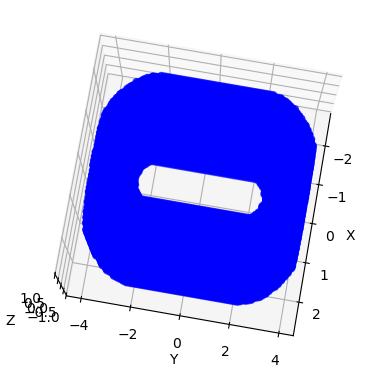

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[link_signed_distances <= 0, 0], reshaped_tensor[link_signed_distances <= 0,1], reshaped_tensor[link_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev= 80, azim=10)
plt.show()

# SDF Scene

In [8]:
def sdScene(parameters):
    '''
    input:
    parameters: num_shapesx6 tensor of parameters for the num_shapes shapes in the scene

    return:
    final_signed_distances: list of signed distances having shape (num_shapes, no_points)
    '''
    final_signed_distances = []
    num_shapes = parameters.shape[0]

    # Iterate over each shape in the parameters tensor
    for i in range(num_shapes):
        r = 0.4
        center = parameters[i, 0:3]
        angles = parameters[i, 3:6]
        sphere_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
        final_signed_distances.append(sphere_signed_distances)

    stacked_final_signed_distances = torch.stack(final_signed_distances, dim=1)  
    return num_shapes, stacked_final_signed_distances

In [9]:
def define_shape(points_2d):
    '''
    returns: (points_2d x 1) tensor having values 1 if the point is inside the triangle and 0 otherwise
    '''
    # Define the vertices of the triangle
    vertices = [(0.5, 0.5), (0.5, 4), (3, 2)]

    # Create a Path object from the vertices
    triangle = Path(vertices)
    print("points_2d inside define_shape: ", points_2d)
    points_2d_cpu = points_2d.to('cpu')
    points_2d = points_2d_cpu.numpy()
    # Check if each point is inside or outside the triangle
    inside = triangle.contains_points(points_2d)
    inside = inside.astype(np.float32)
    inside = torch.tensor(inside, dtype=torch.float32, device=device)

    return inside

In [10]:
def define_shape_V(points_2d):
    '''
    returns: (points_2d x 1) tensor having values 1 if the point is inside the triangle and 0 otherwise
    '''
    # Define the vertices of the triangle
    vertices = [(0.5, 4), (1, 4), (1.5, 1.5), (2,4), (2.5, 4), (2, 0.5), (1, 0.5)]

    # Create a Path object from the vertices
    triangle = Path(vertices)
    print("points_2d inside define_shape_V: ", points_2d)
    points_2d_cpu = points_2d.to('cpu')
    points_2d = points_2d_cpu.numpy()
    # Check if each point is inside or outside the triangle
    inside = triangle.contains_points(points_2d)
    inside = inside.astype(np.float32)
    inside = torch.tensor(inside, dtype=torch.float32, device=device)

    return inside

In [11]:
point_xy = reshaped_tensor[:, 0:2]
point_xy = torch.unique(point_xy, dim=0)
point_xy = point_xy.to(device)
print("point_xy: ", point_xy)
print("point_xy shape:", point_xy.shape)
point_xy_union = torch.cat([point_xy, torch.zeros(point_xy.shape[0], 1, device=device)], dim=1)
print("point_xy_union:", point_xy_union)
print("point_xy_union shape:", point_xy_union.shape)

point_xy:  tensor([[-2.0000, -2.0000],
        [-2.0000, -1.9698],
        [-2.0000, -1.9397],
        ...,
        [ 4.0000,  3.9397],
        [ 4.0000,  3.9698],
        [ 4.0000,  4.0000]])
point_xy shape: torch.Size([40000, 2])
point_xy_union: tensor([[-2.0000, -2.0000,  0.0000],
        [-2.0000, -1.9698,  0.0000],
        [-2.0000, -1.9397,  0.0000],
        ...,
        [ 4.0000,  3.9397,  0.0000],
        [ 4.0000,  3.9698,  0.0000],
        [ 4.0000,  4.0000,  0.0000]])
point_xy_union shape: torch.Size([40000, 3])


In [12]:
# Defining Triangular shape
inside = define_shape(point_xy)
inside = inside.to(device)
print("inside.shape: ", inside.shape)
pts_inside = torch.cat([point_xy, inside.reshape(point_xy.shape[0], 1)], dim=1)
print("pts_inside.shape: ", pts_inside.shape)

print(inside)
print(inside.sum())

points_2d inside define_shape:  tensor([[-2.0000, -2.0000],
        [-2.0000, -1.9698],
        [-2.0000, -1.9397],
        ...,
        [ 4.0000,  3.9397],
        [ 4.0000,  3.9698],
        [ 4.0000,  4.0000]])
inside.shape:  torch.Size([40000])
pts_inside.shape:  torch.Size([40000, 3])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor(4864.)


In [13]:
# Defining V-shape
inside_V = define_shape_V(point_xy)
inside_V = inside_V.to(device)
print("inside_V.shape: ", inside_V.shape)
pts_inside_V = torch.cat([point_xy, inside_V.reshape(point_xy.shape[0], 1)], dim=1)
print("pts_inside.shape: ", pts_inside.shape)

print(inside_V)
print(inside_V.sum())

points_2d inside define_shape_V:  tensor([[-2.0000, -2.0000],
        [-2.0000, -1.9698],
        [-2.0000, -1.9397],
        ...,
        [ 4.0000,  3.9397],
        [ 4.0000,  3.9698],
        [ 4.0000,  4.0000]])
inside_V.shape:  torch.Size([40000])
pts_inside.shape:  torch.Size([40000, 3])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor(4421.)


In [14]:
def plot_union(parameters):
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0].to('cpu')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    # ax.scatter(reshaped_tensor[union_sdf <= 0, 0], reshaped_tensor[union_sdf <= 0,1], reshaped_tensor[union_sdf <= 0, 2], c='blue', marker='o')
    ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], reshaped_tensor_cpu[union_sdf <= 0, 2], c='blue', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev= 90, azim=-90)
    plt.show()

In [15]:
def plot_intersections(parameters):
    '''
    get intersection matrix and plot intersections
    '''
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    intersection_mat = [[None for _ in range(num_shapes)] for _ in range(num_shapes)]       # creating empty list of lists of size num_shapes x num_shape
    fig = plt.figure(figsize=(10, 10))  # create a figure object
    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    for i in range(num_shapes):
        for j in range(i+1, num_shapes):
            intersection_mat[i][j] = torch.max(stacked_final_signed_distances[:, i], stacked_final_signed_distances[:, j]).to('cpu')
            ax = fig.add_subplot(num_shapes, num_shapes, i*num_shapes+j+1, projection='3d')
            ax.scatter(reshaped_tensor_cpu[intersection_mat[i][j] <= 0, 0], reshaped_tensor_cpu[intersection_mat[i][j] <= 0,1], reshaped_tensor_cpu[intersection_mat[i][j] <= 0, 2], c='blue', marker='o')
 
    # Set horizontal and vertical space between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

In [16]:
def plot_shape(parameters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    point_xy_cpu = point_xy.to('cpu')
    inside_cpu = inside.to('cpu')
    ax.scatter(point_xy_cpu[inside_cpu > 0, 0], point_xy_cpu[inside_cpu > 0,1], c='blue', marker='o')
    # ax.view_init(elev= 80, azim=10)
    plt.show()

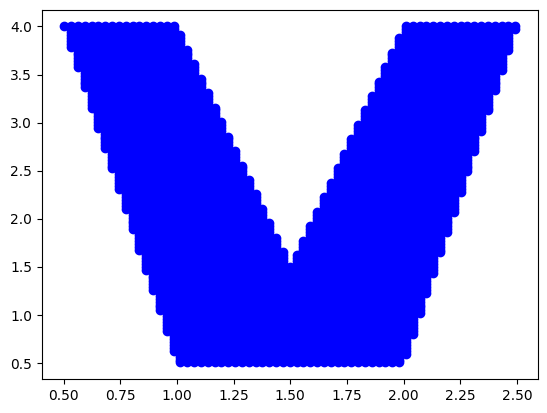

In [17]:
def plot_shape_V():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    point_xy_cpu = point_xy.to('cpu')
    inside_V_cpu = inside_V.to('cpu')
    ax.scatter(point_xy_cpu[inside_V_cpu > 0, 0], point_xy_cpu[inside_V_cpu > 0,1], c='blue', marker='o')
    # ax.view_init(elev= 80, azim=10)
    plt.show()
plot_shape_V()

In [18]:
# Just testing
reshaped_tensor.shape[0]
axis_num_pts
inside.shape

torch.Size([40000])

In [19]:
def calulate_loss(num_shapes, stacked_final_signed_distances):
    print("inside calulate_loss, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    
    # Intersection Loss
    intersection_loss = 0
    intersection_mat = [[None for _ in range(num_shapes)] for _ in range(num_shapes)] # creating empty list of lists of size num_shapes x num_shape
    
    for i in range(num_shapes):
        for j in range(i+1, num_shapes):
            intersection_mat[i][j] = torch.max(stacked_final_signed_distances[:, i], stacked_final_signed_distances[:, j])
            intersection_loss += torch.sum(intersection_mat[i][j][intersection_mat[i][j] <= 0])

    intersection_loss = - intersection_loss/num_shapes
    print('Intersection Loss: ', intersection_loss)
    
    # Projection Loss
    stacked_final_signed_distances_relu = torch.relu(-stacked_final_signed_distances)
    projection_loss = 0

    f = 0
    for k in range(0, reshaped_tensor.shape[0], axis_num_pts):
        sum_for_a_point_relu = stacked_final_signed_distances_relu[k:k+axis_num_pts, :].sum()
        projection_loss += (sum_for_a_point_relu/(sum_for_a_point_relu+0.0001) - inside[f]).pow(2)
        f+=1
    print('Projection Loss: ', projection_loss)

    # Total Loss
    loss = intersection_loss + projection_loss
    print('Total Loss: ', loss)
    
    return loss.float()

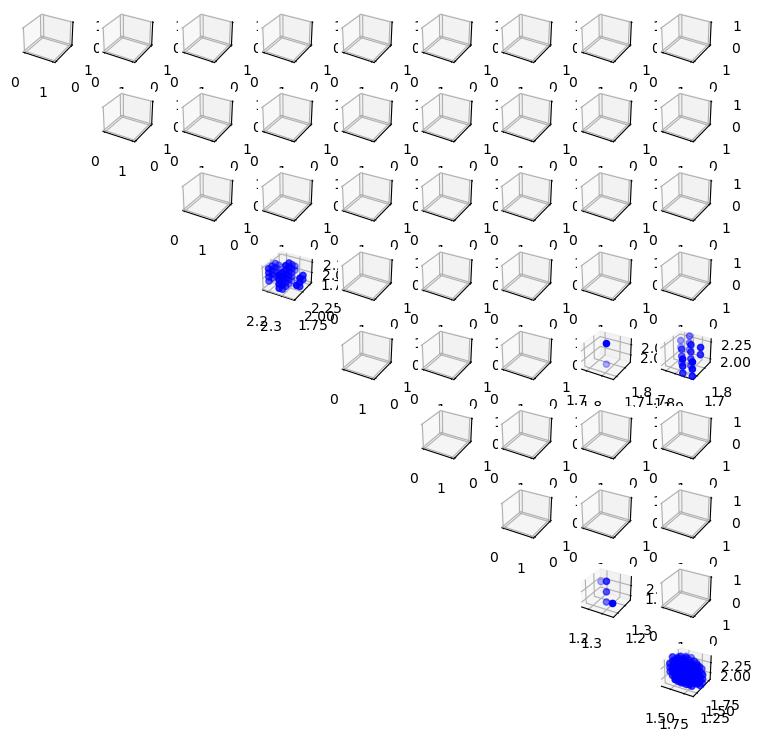

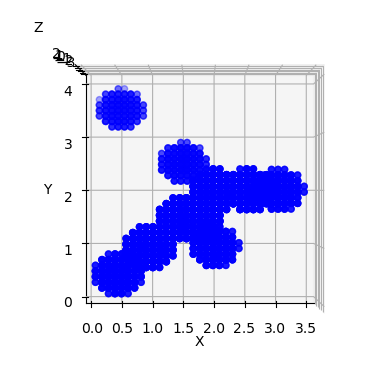

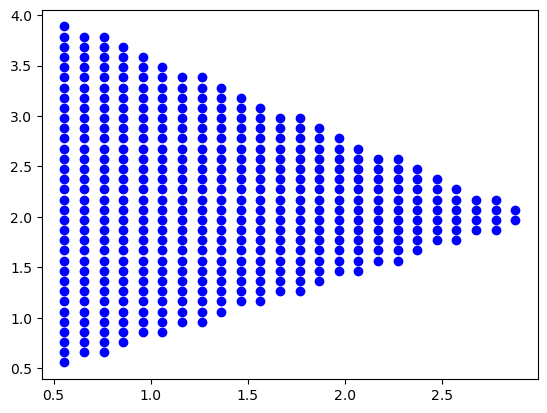

parameters.grad:  None
Iteration:  0
inside calulate_loss, stacked_final_signed_distances.requires_grad:  True
Intersection Loss:  tensor(1.2300, grad_fn=<DivBackward0>)
Projection Loss:  tensor(356.6208, grad_fn=<AddBackward0>)
Total Loss:  tensor(357.8509, grad_fn=<AddBackward0>)
Gradients:
21.866121292114258
Gradient before update: tensor(22.9695)
Gradient after update: tensor(22.9695)
Total Loss:  tensor(357.8509, grad_fn=<AddBackward0>)
Parameter containing:
tensor([[ 4.0000e-01,  4.0000e-01,  2.2753e-03,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.9000e+00,  1.9000e+00, -4.9779e-03,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.9000e+00,  1.1000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.6000e+00,  2.1000e+00,  1.9000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.9000e+00,  2.1000e+00,  1.9000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 6.0000e-01,  3.4000e+00, -3.1000e+00,

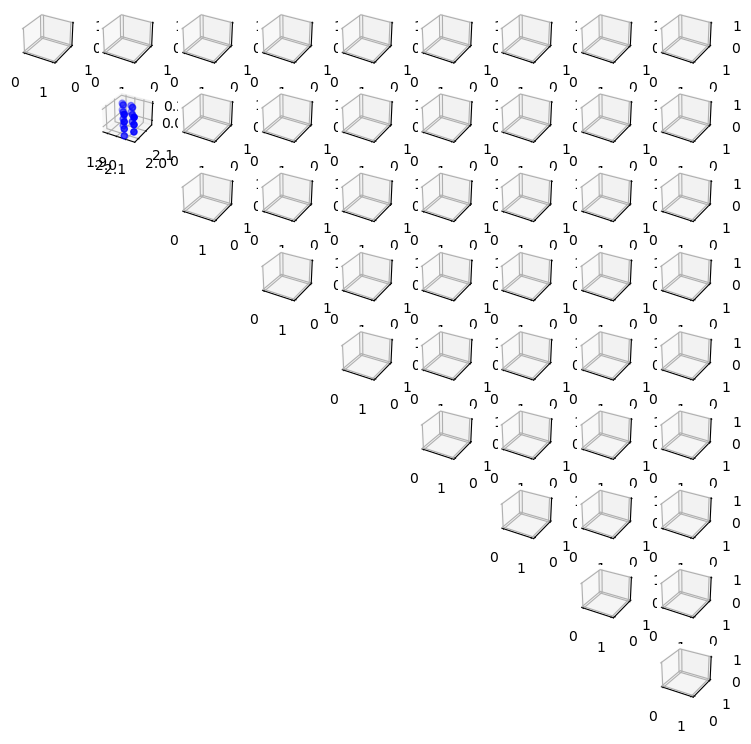

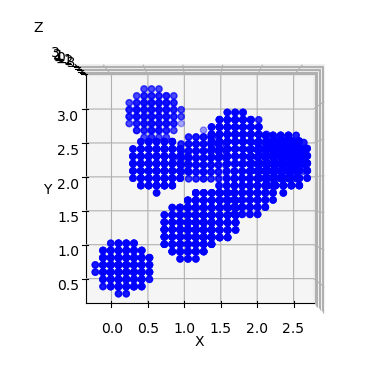

Final Learning Rate:  1.0000000000000005e-08


In [23]:
parameters = [[0.5,0.5,0,0,0,0], [3,2,0,0,0,0], [2,1,0,0,0,0], [2.5,2,2,0,0,0], [2,2,2,0,0,0], [0.5,3.5,-3,0,0,0], [1.5,2.5,-2,0,0,0], [1,1,2,0,0,0], [1.5,1.5,2,0,0,0], [1.7,1.5,2.2,0,0,0]]
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)
parameters = torch.nn.Parameter(parameters)
plot_intersections(parameters)
plot_union(parameters)
plot_shape(parameters)
lr=0.1
optimizer = torch.optim.Adam([parameters], lr=lr)
print("parameters.grad: ", parameters.grad) # it will show none as we have not called backward() yet

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

for i in range(150):
    print('Iteration: ', i)
    optimizer.zero_grad()
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    loss = calulate_loss(num_shapes, stacked_final_signed_distances)
    loss.backward()
    print('Gradients:')
    if parameters.grad is not None:
        print(parameters.grad.norm(2).item())

    print("Gradient before update:", parameters.grad.sum())
    optimizer.step()
    scheduler.step(loss)
    print("Gradient after update:", parameters.grad.sum())
    if(i%2 == 0):
        print('Total Loss: ', loss)
        print(parameters)

plot_intersections(parameters)
plot_union(parameters)
final_lr = optimizer.param_groups[0]['lr']
print('Final Learning Rate: ', final_lr)

In [20]:
def plot_shape_and_union(parameters):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the shape
    # ax.scatter(point_xy[inside > 0, 0], point_xy[inside > 0,1], c='blue', marker='o')
    point_xy_cpu = point_xy.to('cpu')
    inside_cpu = inside.to('cpu')
    ax.scatter(point_xy_cpu[inside_cpu > 0, 0], point_xy_cpu[inside_cpu > 0,1], c='blue', marker='o')
    # ax.view_init(elev= 80, azim=10)
    # plt.show()

    # Plot the union
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0].to('cpu')
    
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    # ax.scatter(reshaped_tensor[union_sdf <= 0, 0], reshaped_tensor[union_sdf <= 0,1], reshaped_tensor[union_sdf <= 0, 2], c='blue', marker='o')
    # ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], reshaped_tensor_cpu[union_sdf <= 0, 2], c='red', marker='o')
    ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], c='red', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    # ax.view_init(elev= 90, azim=-90)
    plt.show()

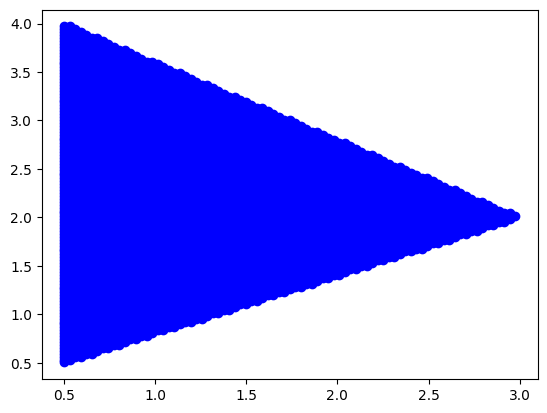

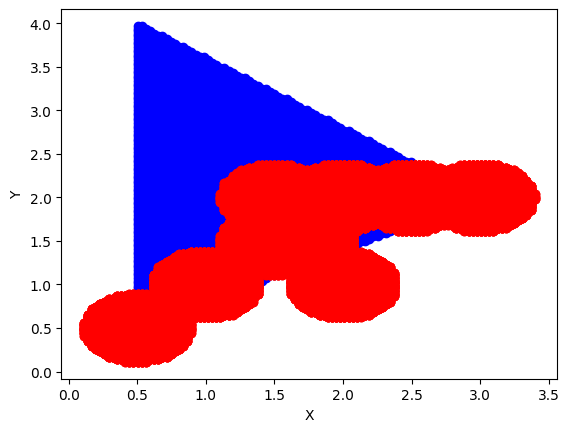

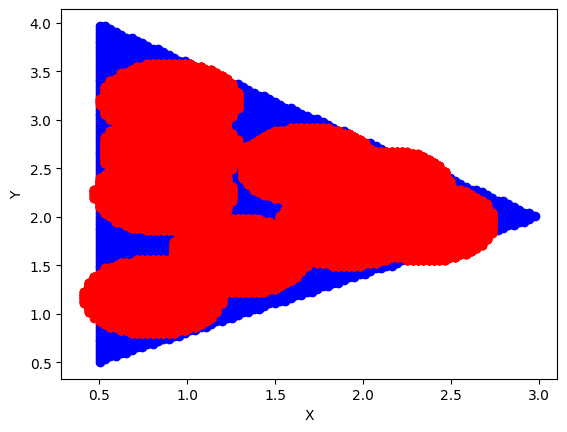

In [32]:
# before the optimization
initial_parameters = torch.tensor([[0.5,0.5,0,0,0,0], [3,2,0,0,0,0], [2,1,0,0,0,0], [2.5,2,2,0,0,0], [2,2,2,0,0,0], [0.5,3.5,-3,0,0,0], [1.5,2,-2,0,0,0], [1,1,2,0,0,0], [1.5,1.5,2,0,0,0], [1.7,1.5,2.2,0,0,0]], requires_grad=True)

# after the optimization
final_parameters = torch.tensor([[0.9,  3.2, -0.5843,  0.0000,  0.0000,  0.0000],
        [ 2.1045,  2.3033, -1.4470,  0.0000,  0.0000,  0.0000],
        [ 2.3518,  1.9407,  0.5938,  0.0000,  0.0000,  0.0000],
        [ 1.6866,  2.5325,  1.7552,  0.0000,  0.0000,  0.0000],
        [ 1.9019,  1.8853,  2.5356,  0.0000,  0.0000,  0.0000],
        [ 0.9019,  3.1699, -2.7858,  0.0000,  0.0000,  0.0000],
        [ 0.9041,  2.6803, -1.6797,  0.0000,  0.0000,  0.0000],
        [ 0.8051,  1.1756,  1.6241,  0.0000,  0.0000,  0.0000],
        [ 0.8665,  2.2409,  1.1161,  0.0000,  0.0000,  0.0000],
        [ 1.2943,  1.5964,  3.7504,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

plot_shape(initial_parameters)
plot_shape_and_union(initial_parameters)
plot_shape_and_union(final_parameters)